In [1]:
#Imports#
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import glob
from PIL import Image
import pandas as pd
from utils_fn import *

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X_train,Y_train,X_test,Y_test = load_dataset()

In [3]:
print("X_train shape :",X_train.shape)
print("Y_train shape :",Y_train.shape)
print("X_test shape :",X_test.shape)
print("Y_test shape :",Y_test.shape)

X_train shape : (8216, 100, 100, 3)
Y_train shape : (8216, 17)
X_test shape : (2754, 100, 100, 3)
Y_test shape : (2754, 17)


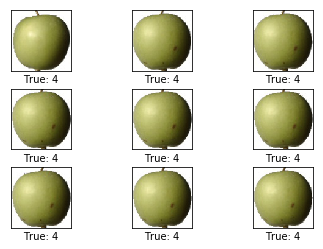

In [4]:
plot_images(X_train[2001:2010,:,:,:],Y_train[2001:2010,])

In [5]:
# shuffling dataset
idx = np.random.permutation(len(X_train))
X_train,Y_train = X_train[idx], Y_train[idx]
idx = np.random.permutation(len(X_test))
X_test,Y_test = X_test[idx], Y_test[idx]

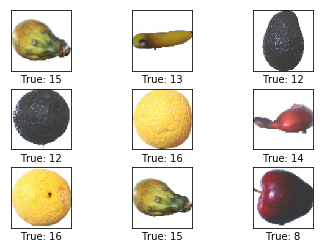

In [6]:
#plotting sample shuffled images w/ one-hot
plot_images(X_train[1:10,:,:,:],Y_train[1:10,])

In [7]:
#validation_size = 2000
pixel_depth = 255.0  
image_width = 100
image_height = 100
num_channels = 3
num_classes = 17
img_size = X_train.shape[1]
num_channels = X_train.shape[-1]
num_classes = Y_train.shape[1] 

In [8]:
### Let's apply normalization to our images.
X_train = (X_train.astype(float) - 
                    pixel_depth / 2) / pixel_depth


X_test = (X_test.astype(float) - 
                    pixel_depth / 2) / pixel_depth

In [9]:
print("X_train shape :",X_train.shape)
print("Y_train shape :",Y_train.shape)
print("X_test shape :",X_test.shape)
print("Y_test shape :",Y_test.shape)

X_train shape : (8216, 100, 100, 3)
Y_train shape : (8216, 17)
X_test shape : (2754, 100, 100, 3)
Y_test shape : (2754, 17)


In [9]:
def conv_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name 
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def fc_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """ Creates a new bias variable
    """
    return tf.Variable(tf.constant(0.0, shape=shape))


def conv_layer(input,               # The previous layer
                layer_name,         # Layer name
                num_input_channels, # Num. channels in prev. layer
                filter_size,        # Width and height of each filter
                num_filters,        # Number of filters
                pooling=True):      # Use 2x2 max-pooling

    # Shape of the filter-weights for the convolution
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new filters with the given shape
    weights = conv_weight_variable(layer_name, shape=shape)
    
    # Create new biases, one for each filter
    biases = bias_variable(shape=[num_filters])

    # Create the TensorFlow operation for convolution
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME') # with zero padding

    # Add the biases to the results of the convolution
    layer += biases
    
    # Rectified Linear Unit (RELU)
    layer = tf.nn.relu(layer)

    # Down-sample the image resolution?
    if pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Return the resulting layer and the filter-weights
    return layer, weights


def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    # Return the flattened layer and the number of features.
    return layer_flat, num_features



def fc_layer(input,        # The previous layer
             layer_name,   # The layer name
             num_inputs,   # Num. inputs from prev. layer
             num_outputs,  # Num. outputs
             relu=True):   # Use RELU?

    # Create new weights and biases.
    weights = fc_weight_variable(layer_name, shape=[num_inputs, num_outputs])
    biases = bias_variable(shape=[num_outputs])

    # Calculate the layer activation
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if relu:
        layer = tf.nn.relu(layer)

    return layer

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # 

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 32         # 

# Fully-connected layer.
fc_size = 64


x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, num_channels), name='x')
y_true = tf.placeholder(tf.float32, shape=[None, 6], name='y_true')

y_true_cls = tf.argmax(y_true, dimension=1)
keep_prob = tf.placeholder(tf.float32)

conv_1, w_c1 = conv_layer(input=x,
                          layer_name="conv_1",
                          num_input_channels=num_channels,
                          filter_size=filter_size1,
                          num_filters=num_filters1, pooling=True)

conv_1
conv_2, w_c2 = conv_layer(input=conv_1,
                          layer_name="conv_2",
                          num_input_channels=num_filters1,
                          filter_size=filter_size2,
                          num_filters=num_filters2,
                          pooling=True)

# Apply dropout after the pooling operation
dropout = tf.nn.dropout(conv_2, keep_prob)

dropout


layer_flat, num_features = flatten_layer(dropout)

layer_flat


fc_1 = fc_layer(input=layer_flat,
                layer_name="fc_1",
                num_inputs=num_features,
                num_outputs=fc_size,
                relu=True)

fc_1

fc_2 = fc_layer(input=fc_1,
                layer_name="fc_2",
                num_inputs=fc_size,
                num_outputs=num_classes,
                relu=False)

fc_2

y_pred = tf.nn.softmax(fc_2)

# The class-number is the index of the largest element.
y_pred_cls = tf.argmax(y_pred, dimension=1)

# Calcualte the cross-entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_2, labels=y_true)

# Take the average of the cross-entropy for all the image classifications.
cost = tf.reduce_mean(cross_entropy)

# Global step is required to compute the decayed learning rate
global_step = tf.Variable(0)

# Apply exponential decay to the learning rate
learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.96, staircase=True)

# Construct a new Adam optimizer
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(cost, global_step=global_step)

# Predicted class equals the true class of each image?
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# Cast predictions to float and calculate the mean
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session = tf.Session()
session.run(tf.global_variables_initializer())

# Number of training samples in each iteration 
batch_size = 64

# Keep probability in dropout layer
dropout = 0.5

total_iterations = 0

def optimize(num_iterations, display_step):
    
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for step in range(num_iterations):

        offset = (step * batch_size) % (Y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = Y_train[offset:(offset + batch_size), :]
        
        feed_dict_train = {x: batch_data, y_true: batch_labels, keep_prob: dropout}

        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every display_step
        if step % display_step == 0:
            
            # Calculate the accuracy on the training-set.
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            print("Minibatch accuracy at step %d: %.4f" % (step, batch_acc))
            
            # Calculate the accuracy on the validation-set
            validation_acc = session.run(accuracy, {x: X_test, y_true: Y_test, keep_prob: 1.0})
            print("Validation accuracy: %.4f" % validation_acc)

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Difference between start and end-times.
    time_diff = time.time() - start_time
    
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))

Instructions for updating:
Use the `axis` argument instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
optimize(num_iterations=31, display_step=10)

Minibatch accuracy at step 0: 1.0000
Validation accuracy: 0.9806
Minibatch accuracy at step 10: 1.0000
Validation accuracy: 0.9760
Minibatch accuracy at step 20: 1.0000
Validation accuracy: 0.9765
Minibatch accuracy at step 30: 1.0000
Validation accuracy: 0.9801
Time usage: 0:02:35


In [22]:
test_pred = session.run(y_pred_cls, {x: X_test[1:10,], keep_prob: 1.0})
print(test_pred[:10])


[3 0 5 0 2 4 5 5 4]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


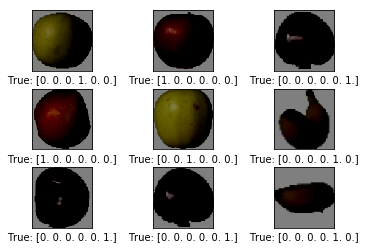

In [18]:
plot_images(X_test[1:10,:,:,:],Y_test[1:10,])